In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.special import softmax
# from utils import denoise_text, preprocess_text

from sklearn.metrics import auc, roc_curve, RocCurveDisplay
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

from IPython.display import display, Markdown, Latex

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
FILE = "datasets/cards_waterloo_augmented.csv"

In [3]:
data = pd.read_csv(FILE, low_memory=False)

In [4]:
def format_scores(x):
    if str(x)!="nan":
        return np.array(eval(re.sub(",? +", " ,", str(x).replace("\n", ""))))
    return

# data[f"cards_pred"] = data[f"cards_pred"].apply(lambda x: int(float(x)))

data["cards_proba"] = data["cards_proba"].apply(format_scores)
data["waterloo_proba"] = data["waterloo_proba"].apply(format_scores)
data["roberta_cards_pipe_proba"] = data["roberta_cards_pipe_proba"].apply(format_scores)
data["roberta_proba"] = data["roberta_proba"].apply(format_scores)
data["bertweet_proba"] = data["bertweet_proba"].apply(format_scores)
data["electra_proba"] = data["electra_proba"].apply(format_scores)
data["xlnet_proba"] = data["xlnet_proba"].apply(format_scores)
data["aug_roberta_proba"] = data["aug_roberta_proba"].apply(format_scores)

### Test Dataset

,Model,AUC,Accuracy,F1-score
0,cards,0.000000,0.212221,0.175068
0,aug_roberta,0.848037,0.936704,0.901059
0,roberta,0.886856,0.939581,0.907602


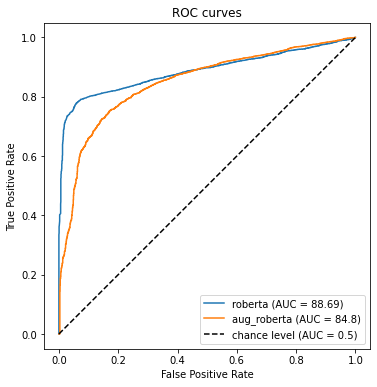

### Randomly Generated TEST CHATGPT

,Model,AUC,Accuracy,F1-score
0,cards,0.0,1.000000,1.000000
0,roberta,NaN,0.957068,0.489032
0,aug_roberta,NaN,0.954974,0.488484


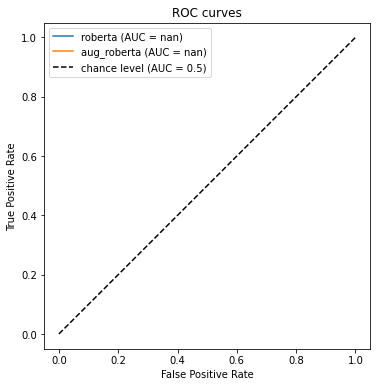

### Randomly Generated Climate Scam CHATGPT

,Model,AUC,Accuracy,F1-score
0,cards,0.0,1.000000,1.000000
0,roberta,NaN,0.968426,0.491980
0,aug_roberta,NaN,0.949186,0.486965


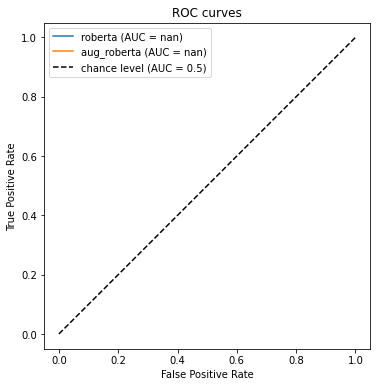

In [5]:
def models_comparative(data, models):
    labels = [0, 1]
    target_names = ["Not Misinformation", "Misinformation"]
    freport = pd.DataFrame()
    
    plt.figure(figsize=(8, 6))
    for model in models:  
        y_true = data.labels.values
        y_pred = data[f"{model}_pred"].values
        if model=="cards":
            y_pred = (data[f"{model}_pred"]!="0_0").astype(int).values
        else: 
            scores = data.apply(lambda x: x[f"{model}_proba"][int(x[f"{model}_pred"])], axis=1).values
            fpr, tpr, thresholds = roc_curve(data.labels, scores)    
            roc_auc = auc(tpr, fpr)# multi_class="ovr", average="macro")
            plt.plot(tpr, fpr, label=f"{model} (AUC = {round(roc_auc*100, 2)})")
        
        acc = accuracy_score(y_true, y_pred)
#         report = classification_report(y_true, y_pred, 
#                                        labels=labels, output_dict=True)

        report = {
            "Model": model,
            "AUC": roc_auc if model!="cards" else 0,
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1-score": f1_score(y_true, y_pred, average='macro')
        }   
        report = pd.DataFrame([report])
        freport = pd.concat([freport, report])
        freport = freport.sort_values(["AUC"])

    display(freport)

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves")
    plt.legend()
    plt.show()
    
# models = ["roberta_cards_pipe", "roberta", "bertweet", "xlnet"]
display(Markdown(f"### Test Dataset"))
# models = ["roberta", "electra", "bertweet", "xlnet"]

test = data[data.PARTITION=="TEST"]
models = ["cards", "roberta", "aug_roberta"]
models_comparative(test, models)

def generated_dataset(file, models):
    data = pd.read_csv(file, low_memory=False)
    for model in models:
        data[f"{model}_pred"] = data[f"{model}_pred"].apply(lambda x: int(float(x)))
        data[f"{model}_proba"] = data[f"{model}_proba"].apply(format_scores)
    data["labels"] = 1
    return data

## Generated from the test partition
test_generated = generated_dataset(
    "datasets/generated_disinformation_binary_TEST_CHATGPT.csv", models)
display(Markdown(f"### Randomly Generated TEST CHATGPT"))
models_comparative(test_generated, models)

## Generated from the ClimateScam partition
climate_scam_generated = generated_dataset(
    "datasets/generated_disinformation_binary_ClimateScam_CHATGPT.csv", models)
display(Markdown(f"### Randomly Generated Climate Scam CHATGPT"))
models_comparative(climate_scam_generated, models)

In [6]:
cards_data = data[data.DATASET=="cards"].copy(deep=True)

In [8]:
cards_data.columns

Index(['Unnamed: 0', 'prompt', 'claim', 'PARTITION', 'labels', 'sentiment',
       'tweetid', 'roberta_preprocessed', 'DATASET', 'text',
       'cards_orignal_pred', 'cards_pred', 'cards_proba', 'waterloo_pred',
       'waterloo_proba', 'roberta_cards_pipe_pred', 'roberta_cards_pipe_proba',
       'roberta_pred', 'roberta_proba', 'bertweet_pred', 'bertweet_proba',
       'gpt-3_curie_pred', 'gpt-3_curie_proba', 'electra_pred',
       'electra_proba', 'xlnet_pred', 'xlnet_proba', 'electra_acc_pred',
       'electra_acc_proba', 'aug_roberta_pred', 'aug_roberta_proba'],
      dtype='object')

In [14]:
cards_data = data[data.DATASET=="cards"].copy(deep=True)

y_true = cards_data.claim.values
y_pred = cards_data.cards_pred.values

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         0_0       0.00      0.00      0.00   19868.0
         1.0       0.00      0.00      0.00       0.0
         1_1       0.00      0.00      0.00     421.0
         1_2       0.00      0.00      0.00     184.0
         1_3       0.00      0.00      0.00     284.0
         1_4       0.00      0.00      0.00     606.0
         1_6       0.00      0.00      0.00     236.0
         1_7       0.00      0.00      0.00     539.0
         2_1       0.00      0.00      0.00    1000.0
         2_3       0.00      0.00      0.00     425.0
         3_1       0.00      0.00      0.00     256.0
         3_2       0.00      0.00      0.00     424.0
         3_3       0.00      0.00      0.00     405.0
         4_1       0.00      0.00      0.00     428.0
         4_2       0.00      0.00      0.00     245.0
         4_4       0.00      0.00      0.00     311.0
         4_5       0.00    

### Randomly Generated TEST CHATGPT

,Model,AUC,Accuracy,F1-score
0,roberta,NaN,0.957068,0.489032
0,aug_roberta,NaN,0.954974,0.488484


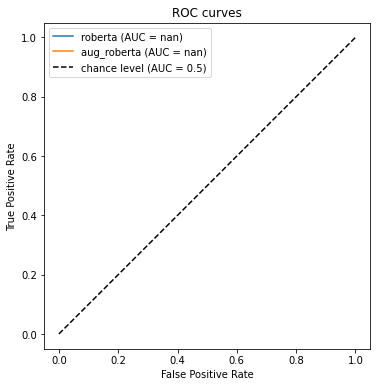

In [7]:
test_generated = pd.read_csv("datasets/generated_disinformation_binary_TEST_CHATGPT.csv", low_memory=False)
test_generated["roberta_proba"] = test_generated["roberta_proba"].apply(format_scores)
test_generated["aug_roberta_proba"] = test_generated["aug_roberta_proba"].apply(format_scores)
test_generated["labels"] = 1

display(Markdown(f"### Randomly Generated TEST CHATGPT"))
models_comparative(test_generated, models)

In [22]:
generated.roberta_pred.value_counts()

1.0    8794
0.0     306
Name: roberta_pred, dtype: int64

In [16]:
from transformers import ElectraTokenizer, ElectraModel
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch

In [17]:
tokenizer = AutoTokenizer.from_pretrained('new_training/experiments/results/electra/best-epoch')
model = AutoModelForSequenceClassification.from_pretrained('new_training/experiments/results/electra/best-epoch')

In [13]:
test.prompt.sample()

70138    @stevenburns131 Are you saying he DOESN'T believe in global warming/climate change?
Name: prompt, dtype: object

In [18]:
inputs = tokenizer(
    "@stevenburns131 Are you saying he DOESN'T believe in global warming/climate change?", return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs[0] 
last_hidden_states

tensor([[-0.0493,  0.0259]], grad_fn=<AddmmBackward>)

In [19]:
inputs = tokenizer(
    "whatever thing", return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs[0] 
last_hidden_states

tensor([[-0.0493,  0.0259]], grad_fn=<AddmmBackward>)

## Roberta

Accuracy: 0.9395807644882861
AUC: 0.8868555870547618


,precision,recall,f1-score,support
Not Misinformation,0.954304,0.969739,0.961960,5750.000000
Misinformation,0.880495,0.827631,0.853245,1549.000000
accuracy,0.939581,0.939581,0.939581,0.939581
macro avg,0.917399,0.898685,0.907602,7299.000000
weighted avg,0.938640,0.939581,0.938888,7299.000000


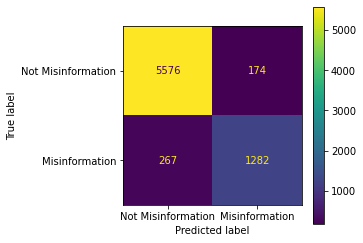

In [6]:
def report(y_true, y_pred, scores, classes, matrix_display=True):
    
    acc = accuracy_score(y_true, y_pred)
    
    scores = np.stack(scores.values)
    scores = scores[np.arange(scores.shape[0]), y_pred]
    
    fpr, tpr, thresholds = roc_curve(y_true, scores)    
    roc_auc = auc(tpr, fpr)# multi_class="ovr", average="macro")

    print(f"Accuracy: {acc}")
    print(f"AUC: {roc_auc}")
    
    if matrix_display:
        c_m = confusion_matrix(y_true, y_pred)
        cmp = ConfusionMatrixDisplay(
            c_m, display_labels=classes)
        fig, ax = plt.subplots(figsize=(4,4))
        cmp.plot(ax=ax)  
    
    report = pd.DataFrame(
        classification_report(y_true, y_pred, target_names=classes, output_dict=True)).transpose()
    
    display(report)
    
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
scores = test['roberta_proba'].apply(lambda x: sum(x[1:]))
# scores = test.apply(lambda x: x[f"{model}_proba"][x[f"{model}_pred"]], axis=1).values
report(test.labels, test['roberta_pred'], test['roberta_proba'], target_names)

Accuracy: 0.9635949943117179
AUC: 0.9695234081198993


,precision,recall,f1-score,support
Not Misinformation,0.979260,0.980731,0.979995,3996.000000
Misinformation,0.804071,0.791980,0.797980,399.000000
accuracy,0.963595,0.963595,0.963595,0.963595
macro avg,0.891666,0.886355,0.888987,4395.000000
weighted avg,0.963356,0.963595,0.963471,4395.000000


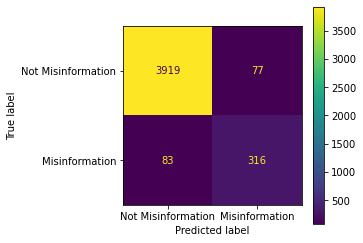

In [6]:
test_twitter = test[~test.tweetid.isna()]
scores = test_twitter['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test_twitter.labels, test_twitter['roberta_new_pipe_pred'], scores, target_names)

Accuracy: 0.903236914600551
AUC: 0.961584700808091


,precision,recall,f1-score,support
Not Misinformation,0.900054,0.944698,0.921836,1754.000000
Misinformation,0.908749,0.840000,0.873023,1150.000000
accuracy,0.903237,0.903237,0.903237,0.903237
macro avg,0.904402,0.892349,0.897429,2904.000000
weighted avg,0.903497,0.903237,0.902506,2904.000000


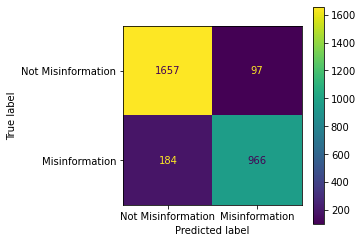

In [7]:
test_cards = test[test.tweetid.isna()]
scores = test_cards['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['roberta_new_pipe_pred'], scores, target_names)

Accuracy: 0.9341005617207837
AUC: 0.9715538215398434


,precision,recall,f1-score,support
Not Misinformation,0.946753,0.970957,0.958702,5750.000000
Misinformation,0.880884,0.797289,0.837004,1549.000000
accuracy,0.934101,0.934101,0.934101,0.934101
macro avg,0.913819,0.884123,0.897853,7299.000000
weighted avg,0.932774,0.934101,0.932875,7299.000000


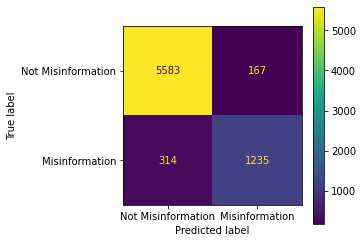

In [11]:
scores = test['roberta_cards_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['roberta_cards_pipe_pred'], scores, target_names)

## Bertweet

Accuracy: 0.935881627620222
AUC: 0.9721501670081679


,precision,recall,f1-score,support
Not Misinformation,0.950683,0.968870,0.959690,5750.000000
Misinformation,0.875608,0.813428,0.843373,1549.000000
accuracy,0.935882,0.935882,0.935882,0.935882
macro avg,0.913145,0.891149,0.901532,7299.000000
weighted avg,0.934750,0.935882,0.935005,7299.000000


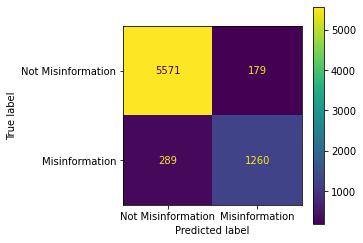

In [8]:
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
scores = test['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['bertweet_pred'], scores, target_names)

Accuracy: 0.9620022753128555
AUC: 0.9724009724009725


,precision,recall,f1-score,support
Not Misinformation,0.977312,0.980981,0.979143,3996.000000
Misinformation,0.802083,0.771930,0.786718,399.000000
accuracy,0.962002,0.962002,0.962002,0.962002
macro avg,0.889698,0.876455,0.882931,4395.000000
weighted avg,0.961404,0.962002,0.961674,4395.000000


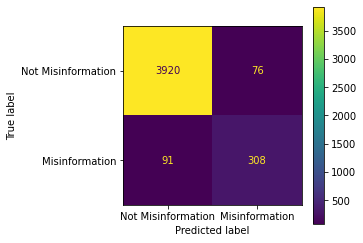

In [9]:
scores = test_twitter['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_twitter.labels, test_twitter['bertweet_pred'], scores, target_names)

Accuracy: 0.8963498622589532
AUC: 0.9585196569332208


,precision,recall,f1-score,support
Not Misinformation,0.892915,0.941277,0.916459,1754.00000
Misinformation,0.902370,0.827826,0.863492,1150.00000
accuracy,0.896350,0.896350,0.896350,0.89635
macro avg,0.897642,0.884552,0.889975,2904.00000
weighted avg,0.896659,0.896350,0.895484,2904.00000


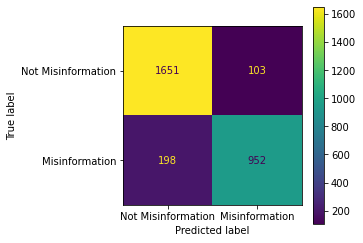

In [10]:
scores = test_cards['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['bertweet_pred'], scores, target_names)

## Electra

In [10]:
data["PARTITION"].value_counts()

TRAIN    58590
TEST      7299
VALID     6999
Name: PARTITION, dtype: int64

In [20]:
valid = data[data["PARTITION"] == "VALID"]

In [11]:
valid.labels.value_counts()

0    5807
1    1192
Name: labels, dtype: int64

In [14]:
(~valid.tweetid.isna()).value_counts()

True     4394
False    2605
Name: tweetid, dtype: int64

In [15]:
data["electra_acc_proba"] = data["electra_acc_proba"].apply(format_scores)

In [19]:
scores = np.stack(data["electra_acc_proba"].values)
scores

array([[0.08122917, 0.91877079],
       [0.58114386, 0.41885614],
       [0.09896884, 0.90103114],
       ...,
       [0.10744187, 0.89255816],
       [0.98637009, 0.0136299 ],
       [0.98025572, 0.01974427]])

Accuracy: 0.909558508358337
AUC: 0.8756317589393963


,precision,recall,f1-score,support
Not Misinformation,0.948976,0.941622,0.945285,5807.000000
Misinformation,0.725950,0.753356,0.739399,1192.000000
accuracy,0.909559,0.909559,0.909559,0.909559
macro avg,0.837463,0.847489,0.842342,6999.000000
weighted avg,0.910992,0.909559,0.910220,6999.000000


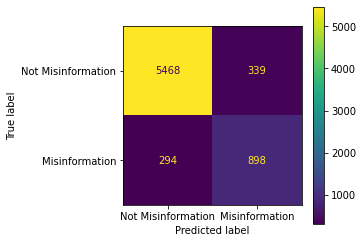

In [21]:
# scores = valid['electra_proba'].apply(lambda x: sum(x[1:]))
report(valid.labels, valid['electra_acc_pred'], valid['electra_acc_proba'], target_names)

## XLnet

Accuracy: 0.9335525414440334
AUC: 0.9692730794060684


,precision,recall,f1-score,support
Not Misinformation,0.948238,0.968522,0.958272,5750.000000
Misinformation,0.873072,0.803744,0.836975,1549.000000
accuracy,0.933553,0.933553,0.933553,0.933553
macro avg,0.910655,0.886133,0.897624,7299.000000
weighted avg,0.932286,0.933553,0.932531,7299.000000


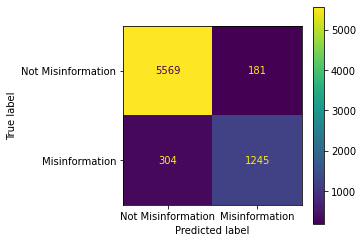

In [9]:
scores = test['xlnet_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['xlnet_pred'], scores, target_names)

## GPT-3 Curie

In [50]:
filter_ = test['gpt-3_curie_pred'].isin(['0', '1'])
filter_.value_counts(normalize=True)

True     0.968078
False    0.031922
Name: gpt-3_curie_pred, dtype: float64

In [51]:
test_filtered = test[filter_]

In [53]:
data["gpt-3_curie_proba"]

0        0.927922
1        0.973415
2        0.659627
3        0.740526
4        0.932434
           ...   
72883    0.568256
72884    0.751197
72885    0.999858
72886    0.999939
72887    0.999523
Name: gpt-3_curie_proba, Length: 72888, dtype: float64

Accuracy: 0.9506085479762242
AUC: 0.713973749243664


,precision,recall,f1-score,support
Not Misinformation,0.951911,0.987262,0.969265,5574.000000
Misinformation,0.944747,0.813673,0.874325,1492.000000
accuracy,0.950609,0.950609,0.950609,0.950609
macro avg,0.948329,0.900468,0.921795,7066.000000
weighted avg,0.950399,0.950609,0.949218,7066.000000


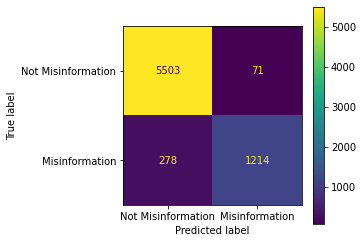

In [56]:
# scores = test_filtered.apply(
#     lambda x: x['gpt-3_curie_proba'] if ['gpt-3_curie_pred']==0 else 1-x['gpt-3_curie_proba'], axis=1)
report(test_filtered.labels, test_filtered['gpt-3_curie_pred'].apply(int), 
       test_filtered["gpt-3_curie_proba"].values, target_names)

In [14]:
data_analysis = data[(data.labels==1) & (data.roberta_new_pipe_pred==0) & (data["gpt-3_curie_pred"]=='1')][[
    "prompt", "roberta_new_pipe_pred", "gpt-3_curie_pred"]]
data_analysis

,prompt,roberta_new_pipe_pred,gpt-3_curie_pred
644,"The cool conditions experienced in autumn 2011 are largely a result of the strong 2010/11 La Nia event which brought heavy rainfall and cool daytime temperatures to Australia, before decaying in late autumn. Of particular significance was March 2011 Australias coldest and wettest March on record for maximum temperatures and third wettest month on record (for any calendar month).",0,1
2547,"Most of us gathered here are not climatologists or scientists in related disciplines of natural sciences, but economists, lawyers, sociologists and perhaps also politicians or ex-politicians who have been for years or decades involved in public policy debates. This is the reason why we follow with such an interest and with an even greater concern the prevailing intellectual and political climate, its biases and misconceptions, as well as its dangerous public policy consequences.",0,1
3386,"Aerosols - suspended particles - in the atmosphere have various effects. Black carbon soot absorbs sunlight and heats the world up, but most other kinds of aerosol tend to cool things down, mostly by presenting nuclei for clouds to form on and so reflecting heat back into space. There is widespread scientific agreement, even among firmly pro-warmist researchers, that aerosols have powerful effects - but just how much aerosol can be expected in the atmosphere of the future is not at all well known, and current models aren't thought to handle this factor at all well.",0,1
5752,"8 pm: Jaeah Lee, a nice fact-checker from Mother Jones, has a genial online video in which she tries (unsuccessfully) to figure out the trick to hide the decline, eventually being tricked by Briffa.",0,1
8249,"Pauses as long as 15 years are rare in the simulations, and we expect that warming will resume in the next few years, the Hadley Centre group writes. Researchers agree that no sort of natural variability can hold off greenhouse warming much longer.",0,1
...,...,...,...
72586,@HillsHugeBeaver @sean_spicier @mariclaire81 Love this. Does climate change cut people's heads off??,0,1
72666,@1thinchip @Bitcoin_IRA They probably just created it to ruin our economy...like global warming.,0,1
72675,If global warming is real then why is there still sno- #snowday #climatechange https://t.co/wCDV3I2Bms,0,1
72719,"@SenGillibrand Do people have anything to do with climate change, Kirsten? If yes, why are you for open borders? Whâ€¦ https://t.co/38z6eRcTfq",0,1
